# Feature scaling and learning rate alpha

In this notebook are implemented:
- Gradient Descent on a data set with multiple features
- the impact of the *learning rate alpha* on gradient descent
- performance of gradient descent by *feature scaling* using z-score normalization

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
np.set_printoptions(precision=2)


In [2]:
def generate_pescara_housing_data(n=200, seed=42):
    """
    Generates synthetic but realistic Pescara-style housing data.
    Returns:
      X -> np.array of shape (n, 4): [size_m2, bedrooms, floors, age]
      y -> np.array of shape (n,): price in thousands of euros
      X_features -> list of feature names
    """
    rng = np.random.default_rng(seed)
    
    # Feature generation (realistic ranges)
    size = rng.uniform(40, 200, n)          # in square meters
    bedrooms = rng.integers(1, 6, n)        # 1 to 5 bedrooms
    floors = rng.integers(1, 4, n)          # 1 to 3 floors
    age = rng.integers(0, 70, n)            # building age in years
    
    # Realistic linear relationship + noise
    # Coefficients represent the "true" model in thousands of euros
    coef_size = 1.8     # 1800 €/m²
    coef_bedroom = 8.0  # +8k € per bedroom
    coef_floor = -2.0   # -2k € per extra floor
    coef_age = -0.3     # -300 € per year old
    intercept = 20.0    # base price 20k €
    
    # Build target prices (in thousands of euros)
    price = (coef_size * size +
             coef_bedroom * bedrooms +
             coef_floor * floors +
             coef_age * age +
             intercept +
             rng.normal(0, 20, n))  # ±20k noise
    
    # Combine features into X matrix and return
    X = np.column_stack((size, bedrooms, floors, age))
    y = price
    X_features = ["Size (m²)", "Bedrooms", "Floors", "Age (yrs)"]
    
    return X, y, X_features

# Example usage:
X_train, y_train, X_features = generate_pescara_housing_data(n=200)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Example row:", X_train[0])
print("Example target (price, 1000€):", y_train[0])


X_train shape: (200, 4)
y_train shape: (200,)
Example row: [163.83   5.     2.     0.  ]
Example target (price, 1000€): 379.5636321162409


First we try to plot each feature vs the price and see how it looks

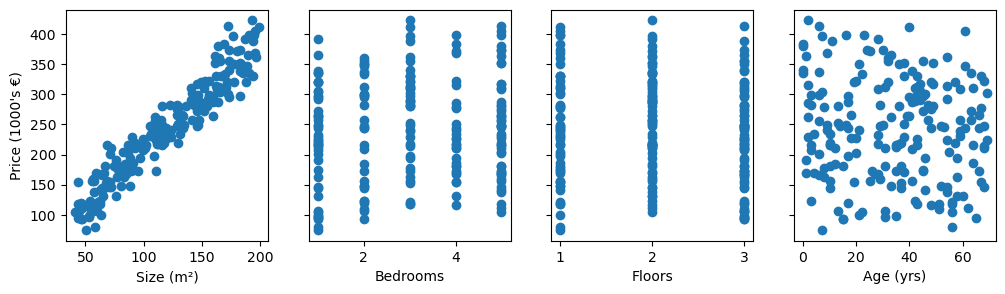

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's €)")
plt.show()

The learning rate controls the size of the update to the parameters. See equation (1) above. It is shared by all the parameters.  

Let's run gradient descent and try a few settings of $\alpha$ on our data set

In [4]:
def compute_cost(X, y, w, b):
    """
    X is the dataset containing m samples of n features with shape (m, n)
    w is the set of weights and has shape (n,)
    b is the bias parameters
    y are the target values with shape (m,)
    The function returns a (scalar) cost
    """

    m = X.shape[0] #initializing m as the number of rows in our dataset (each row represents a set of data)
    cost = 0.0
    for i in range(m): #so that we can iterate over the number of samples passed to it
        f_wb_i = np.dot(X[i], w) + b
        cost = cost + (f_wb_i - y[i])**2
    total_cost = cost/(2*m)
    return total_cost

def compute_gradient(X, y, w, b):
    """
    X array with m examples and n features (our matrix m rows by n columns)
    y array of target values m (one for each sample in our dataset)
    w array of weights for each feature so has size n
    b bias term
    The function returns:
    dj_dw which has the same dimensions of w (n, )
    dj_db which is a scalar 
    """
    m, n = X.shape 
    #this time we dont have to specify X[0] to state that we are referring to a single column
    #in this way we are able to specify that m has to cover the first dimension of our data set: m the number of samples
    #and n will cover the second dimension of our dataset X which belongs to the number of features
    dj_dw = np.zeros((n, ))
    dj_db = 0.
    for i in range(m):
        deviation = (np.dot(X[i], w) + b) - y[i] #loop over each sample
        for j in range(n): #loop over each feature
            dj_dw[j] = dj_dw[j] + deviation*X[i, j]
        dj_db = dj_db + deviation
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    return dj_dw, dj_db

def run_gradient_descent(X, y, num_iters, alpha):
    w = np.zeros(X.shape[1])
    b = 0
    J_hist = []
    w_hist = []
    
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        cost = compute_cost(X, y, w, b)
        J_hist.append(cost)
        w_hist.append(w[0])  # just track w[0] for plotting
        
        if i % max(1, num_iters // 10) == 0:
            print(f"Iteration {i:4d}: Cost {cost:8.2f}")
    
    return w, b, J_hist, w_hist

def plot_cost_i_w(X, y, J_hist, w_hist):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # --- Left plot: Cost vs Iteration ---
    ax[0].plot(np.arange(len(J_hist)), J_hist, 'b-')
    ax[0].set_title("Cost vs Iteration")
    ax[0].set_xlabel("iteration")
    ax[0].set_ylabel("Cost")
    
    # --- Right plot: Cost vs w[0] ---
    w_vals = np.linspace(min(w_hist) - 1, max(w_hist) + 1, 100)
    J_vals = [compute_cost(X, y, np.array([w, 0, 0, 0]), 0) for w in w_vals]
    ax[1].plot(w_vals, J_vals, 'b-', linewidth=2)
    
    # Overlay the gradient descent path (orange line)
    ax[1].plot(w_hist, J_hist, color='orange', marker='o', linewidth=3)
    
    ax[1].set_title("Cost vs w[0]")
    ax[1].set_xlabel("w[0]")
    ax[1].set_ylabel("Cost")
    
    plt.tight_layout()
    plt.show()


Iteration    0: Cost 31805.04
Iteration   10: Cost 22597.87
Iteration   20: Cost 16093.91
Iteration   30: Cost 11499.44
Iteration   40: Cost  8253.78
Iteration   50: Cost  5960.90
Iteration   60: Cost  4341.03
Iteration   70: Cost  3196.57
Iteration   80: Cost  2387.92
Iteration   90: Cost  1816.49


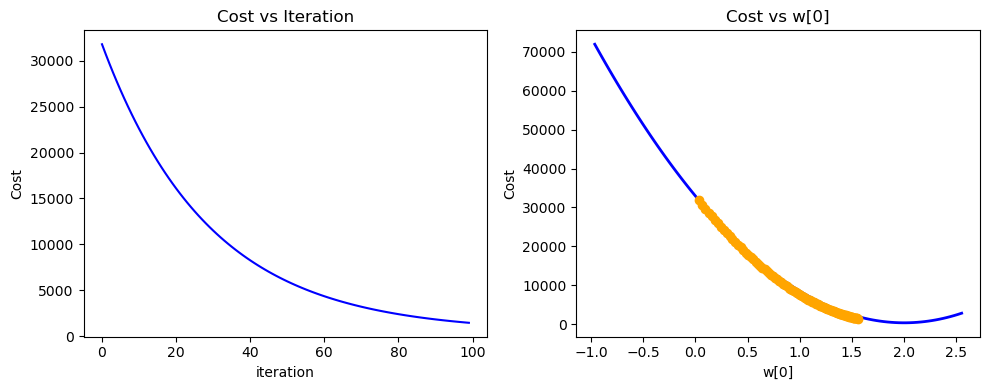

In [14]:
# Run gradient descent with a large alpha (to show oscillation)
w, b, J_hist, w_hist = run_gradient_descent(X_train, y_train, num_iters=100, alpha=1e-6)

# Then plot it
plot_cost_i_w(X_train, y_train, J_hist, w_hist)




### z-score normalization 
After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

**Implementation**

In [10]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 
#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

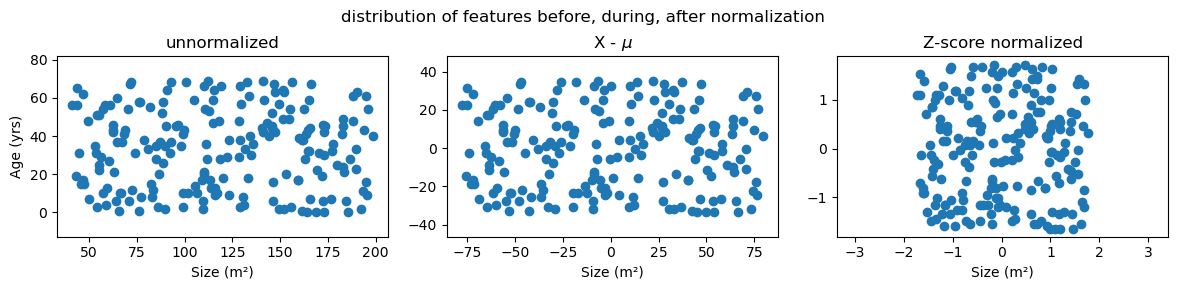

In [11]:
mu     = np.mean(X_train,axis=0)   
sigma  = np.std(X_train,axis=0) 
X_mean = (X_train - mu)
X_norm = (X_train - mu)/sigma      

fig,ax=plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:,0], X_train[:,3])
ax[0].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[0].set_title("unnormalized")
ax[0].axis('equal')

ax[1].scatter(X_mean[:,0], X_mean[:,3])
ax[1].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:,0], X_norm[:,3])
ax[2].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("distribution of features before, during, after normalization")
plt.show()